# 2. EDA

# Prepare data - Jan 2015

In [1]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import contextily as ctx

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Function to retrieve data from postgis as geo df using queries
def get_gdf(query, geom):
    # Connect to the database
    con =  psycopg2.connect(dbname='carto', user='carto', password='carto',
                            host='postgis', port='5432')

    # Save the query result as a geodataframe
    gdf = gpd.read_postgis(query, con, geom_col=geom)
    con.close()
    return gdf

In [3]:
# Query to select 50,000 pickup data from January
q_jan = '''
        with
        
            jan as
            (
                select
                    tpep_pickup_datetime as pickup_time,
                    ST_SetSRID(ST_MakePoint(pickup_longitude, pickup_latitude), 4326) as pickup_point
                from taxi_jan
            )
        
        select jan.*
        from jan, census_blocks as census
        where ST_Contains(census.geometry, jan.pickup_point)
        LIMIT 50000;
        '''

# Save the query result as a geodataframe
pickup_jan = get_gdf(q_jan, 'pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-12 23:51:23,POINT (-73.78431 40.64864)
1,2015-01-12 23:51:24,POINT (-73.99539 40.71761)
2,2015-01-12 23:51:24,POINT (-73.95198 40.77768)
3,2015-01-12 23:51:25,POINT (-73.87446 40.77404)
4,2015-01-12 23:51:26,POINT (-73.99603 40.75387)


In [4]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   50000 non-null  datetime64[ns]
 1   pickup_point  50000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 781.4 KB


In [5]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(50000, 2)

In [6]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(49982, 2)

In [24]:
pickup_jan.pickup_time.dt.date.value_counts()

2015-01-14    2527
2015-01-17    2204
2015-01-31    2142
2015-01-16    2077
2015-01-24    1961
2015-01-13    1959
2015-01-10    1867
2015-01-23    1803
2015-01-01    1764
2015-01-08    1759
2015-01-11    1754
2015-01-28    1689
2015-01-09    1672
2015-01-30    1651
2015-01-19    1614
2015-01-06    1605
2015-01-29    1594
2015-01-22    1593
2015-01-07    1577
2015-01-18    1572
2015-01-21    1534
2015-01-15    1492
2015-01-12    1474
2015-01-20    1469
2015-01-25    1415
2015-01-02    1400
2015-01-03    1311
2015-01-05    1229
2015-01-04    1092
2015-01-26     867
2015-01-27     315
Name: pickup_time, dtype: int64

In [7]:
# Print CRS
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [8]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv', index_col=0)
print(demographic.shape)
demographic.head()

(199630, 3)


,geoid,acs_demog_var,value
0,360050001001,total_pop,7080.0
1,360050001001,two_or_more_races_pop,41.0
2,360050001001,vacant_housing_units_for_rent,0.0
3,360050001001,unemployed_pop,0.0
4,360050001001,black_pop,3984.0


In [9]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {demographic.isnull().any().sum()}')
print(f'How many duplicated rows?: {demographic.duplicated().sum()}')

How many rows with missing values?: 0
How many duplicated rows?: 0


In [10]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [11]:
# Missing or duplicated values?
print(f'How many rows with missing values?: {census.isnull().any().sum()}')
print(f'How many duplicated rows?: {census.duplicated().sum()}')
print(f'How many blocks are there?: {len(census.geoid.unique())}')

How many rows with missing values?: 0
How many duplicated rows?: 0
How many blocks are there?: 6339


In [12]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [13]:
# Change the data type of 'geoid' column
# object -> numeric
census.geoid = pd.to_numeric(census.geoid)
census.geoid.dtype

dtype('int64')

# Visualize the data

In [14]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

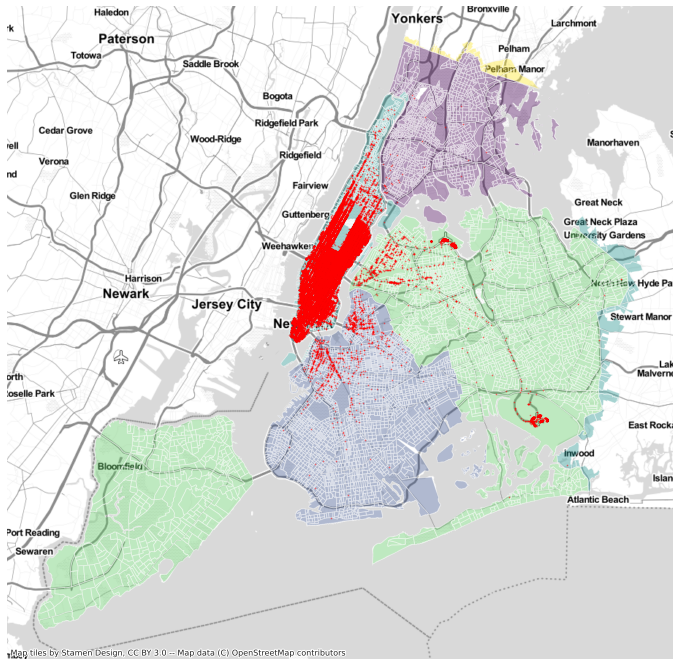

In [15]:
# Plot the census blocks
ax = census.plot(column = 'geoid', figsize=(12, 12), scheme='EqualInterval', alpha=.4, cmap='viridis')

# Plot pickup points within blocks (red points)
pickup_jan.plot(ax=ax, color='red', alpha=.4, markersize=.6)

# Basemap of NY city
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# Spatial join

In [16]:
# Spatial join
pickup_blocks = gpd.sjoin(census, pickup_jan, how='inner', op='intersects')
print(pickup_blocks.shape)
pickup_blocks.head()

(49982, 4)


,geoid,geometry,index_right,pickup_time
11,360050016004,"POLYGON ((-8222288.912 4985463.198, -8222278.2...",42222,2015-01-14 11:59:45
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",12123,2015-01-09 12:30:16
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",29460,2015-01-07 23:33:09
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",695,2015-01-25 02:13:41
12,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",28620,2015-01-15 18:29:27


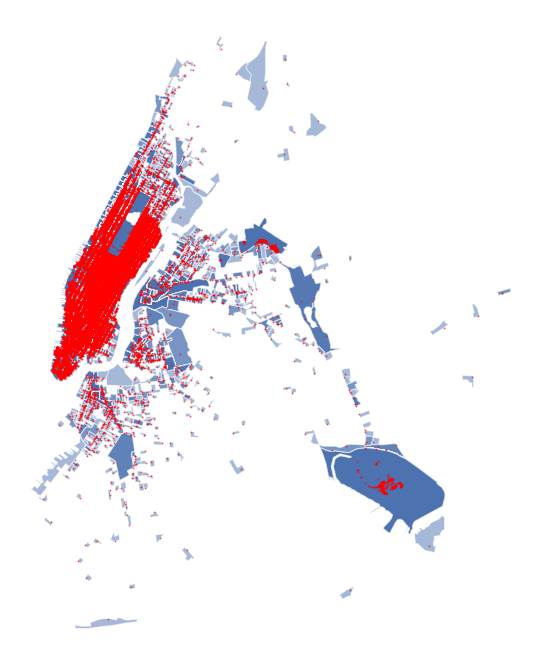

In [17]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(figsize=(15,12), alpha=.5)
pickup_jan.plot(ax=ax, color='red', alpha=.5, markersize=1)
ax.set_axis_off()
plt.show()

In [18]:
# Count how many pickups were made within each block
counted = pickup_blocks.geoid.value_counts()
counted = gpd.GeoDataFrame(counted).reset_index()
counted.columns = ['geoid', 'n_pickup']
counted.head()

,geoid,n_pickup
0,360610101001,1233
1,360810331001,987
2,360810716001,899
3,360610092001,779
4,360610143001,662


In [19]:
pickup_blocks = pickup_blocks.merge(counted, how='inner', on='geoid')
pickup_blocks.head()

,geoid,geometry,index_right,pickup_time,n_pickup
0,360050016004,"POLYGON ((-8222288.912 4985463.198, -8222278.2...",42222,2015-01-14 11:59:45,1
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",12123,2015-01-09 12:30:16,4
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",29460,2015-01-07 23:33:09,4
3,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",695,2015-01-25 02:13:41,4
4,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",28620,2015-01-15 18:29:27,4


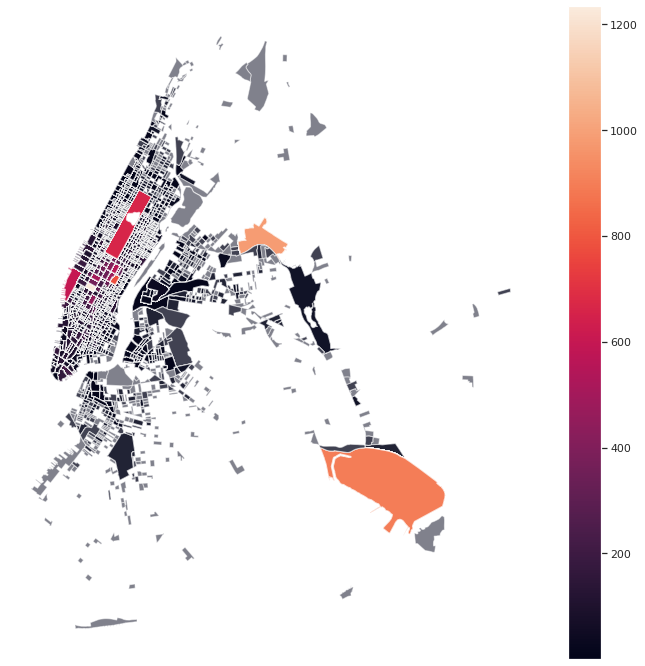

In [20]:
# Visualize the polygons only joined with the points
ax = pickup_blocks.plot(column='n_pickup', figsize=(12,12), alpha=.5, legend=True)
ax.set_axis_off()
plt.show()

In [ ]:
# Get average pickups per area of each block
# Get average pickups per different date types

In [34]:
avg_pickups = pickup_blocks.pivot_table(values='n_pickup',
                                        index='geoid',
                                        aggfunc='mean')
avg_pickups.columns = ['avg_pickup']
avg_pickups.reset_index(inplace=True)
avg_pickups.head()

,geoid,avg_pickup
0,360050016004,1
1,360050019001,4
2,360050019004,1
3,360050043001,1
4,360050051001,6


In [35]:
print(pickup_blocks.shape)
pickup_blocks = pickup_blocks.merge(avg_pickups, how='left', on='geoid')
print(pickup_blocks.shape)
pickup_blocks.head()

(49982, 5)
(49982, 6)


,geoid,geometry,index_right,pickup_time,n_pickup,avg_pickup
0,360050016004,"POLYGON ((-8222288.912 4985463.198, -8222278.2...",42222,2015-01-14 11:59:45,1,1
1,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",12123,2015-01-09 12:30:16,4,4
2,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",29460,2015-01-07 23:33:09,4,4
3,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",695,2015-01-25 02:13:41,4,4
4,360050019001,"POLYGON ((-8229954.372 4984100.032, -8229799.3...",28620,2015-01-15 18:29:27,4,4


In [40]:
pickup_blocks.area

0        539910.638292
1        447740.496121
2        447740.496121
3        447740.496121
4        447740.496121
             ...      
49977    459120.958942
49978     89658.549672
49979    340020.872180
49980    271785.614290
49981    271785.614290
Length: 49982, dtype: float64

In [ ]:
pickup_blocks['weekday'] = pickup_blocks['pickup_time'].dt.weekday
pickup_blocks['month'] = pickup_blocks['pickup_time'].dt.month
pickup_blocks['day'] = pickup_blocks['pickup_time'].dt.day
pickup_blocks.head()

In [ ]:
# Average pickups per weekdays & day of month
fig, ax = plt.subplots(1, 2, figsize=(15,6))

pickup_blocks.groupby('weekday').counts.mean().plot(cmap='Set1',
                                                    marker='o',
                                                    markersize=8,
                                                    linewidth=0.5,
                                                    ax=ax[0])

pickup_blocks.groupby('day').counts.mean().plot(cmap='Set2',
                                                marker='o',
                                                markersize=6,
                                                linewidth=.5,
                                                ax=ax[1])
plt.show()

In [ ]:
pickup_blocks.groupby('day').counts.mean().plot(kind='bar', figsize=(12,6))

In [ ]:
# Population
NY_by_block = demographic.merge(pickup_blocks, on='geoid')
